In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [2]:
filename = 'data/images/signatures/signature3.jpg'
# filename = 'data/images/fingerprints/fingerprint41.jpg'
img = np.asarray(Image.open(filename))

In [13]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

In [14]:
def return_uint8(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.uint8)
    return func_wrapper

def return_float32(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.float32)
    return func_wrapper
@return_uint8
def get_grey_image(img):
    return np.apply_along_axis(_pixel2gray, -1, img)
def _pixel2gray(pixel):
    grey = int(sum(pixel) // 3)  # Average of 3 colors
    return [grey] * len(pixel)

def get_global_thresholding(img, threshold):
    # http://www.cse.iitd.ernet.in/~pkalra/col783/Thresholding.pdf
    img = to_grayscale(img)
    return np.apply_along_axis(_threshold, -1, img, threshold)
def _threshold(pixel, threshold):
    return [1. if color > threshold else 0. for color in pixel]

In [15]:
def otsu_threshold(im):
    pixel_counts = [np.sum(im == i) for i in range(256)]
    s_max = (0,-10)
    ss = []
    for threshold in range(256):
        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])
        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0
        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)
        if s > s_max[1]:
            s_max = (threshold, s)         
    return s_max[0]

(418, 640)
uint8


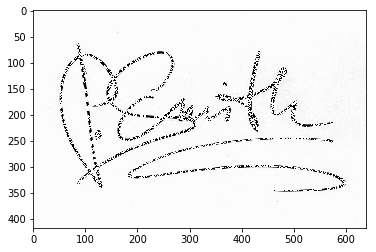

In [16]:
a = get_grey(img)
a = 1-a
print(a.shape)
print(a.dtype)
plt.imshow(a, cmap=plt.cm.binary)

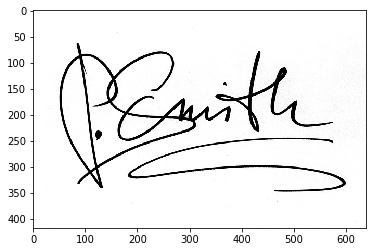

In [17]:
imshow(img)

Threshold: 128
(418, 640)


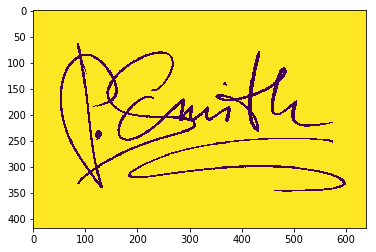

In [18]:
threshold = otsu_threshold(img)
print("Threshold: {}".format(threshold))
binarized = get_global_thresholding(img, threshold)
imshow(binarized)
print(binarized.shape)

In [38]:
def first_marks(img):
    result = np.ndarray(img.shape)
    for (i, j), v in np.ndenumerate(img):
        if img[i, j] == 1:
            result[i,j] = 1
            neighbours = img[i-1:i+2,j-1:j+2]
        try:
            if neighbours[0][1] == 0 or neighbours[1][0] == 0 or neighbours[1][2] == 0 or neighbours[2][1] == 0:
                result[i,j] = 2
            else:
                if neighbours[0][0] == 0 or neighbours[0][2] == 0 or neighbours[2][0] == 0 or neighbours[2][2] == 0:
                    result[i,j] = 3
        except IndexError:
            pass
    return result
        
a = kmm(binarized)

In [32]:
def get_neighbour_weight(neighbours):
    weight = 0
    if neighbours[0][1] != 0:
        weight += 1
    if neighbours[0][2] != 0:
        weight += 2
    if neighbours[1][2] != 0:
        weight += 4
    if neighbours[2][2] != 0:
        weight += 8
    if neighbours[2][1] != 0:
        weight += 16
    if neighbours[2][0] != 0:
        weight += 32
    if neighbours[1][0] != 0:
        weight += 64
    if neighbours[0][0] != 0:
        weight += 128
    return weight

In [33]:
def check_2_3_4_neighbours(neighbours):
    w = get_neighbour_weight(neighbours)
    return w in [3,6,12,24,48,96,192,129,7,13,28,56,112,224,193,131,15,30,60,120,240,225,195,135]

In [35]:
def delete_4s(img):
    result = np.ndarray(img.shape)
    for (i, j), v in np.ndenumerate(img):
        result[i, j] = img[i, j]
        if img[i, j] == 2 or img[i, j] == 3:
            neighbours = img[i-1:i+2,j-1:j+2]
            try:
                if check_2_3_4_neighbours(neighbours):
                    result[i, j] = 0
            except IndexError:
                pass
    return result

In [39]:
DELETION_ARRAY = [
    
]

In [37]:
def delete_ns(img, n):
    result = img
    for (i, j), v in np.ndenumerate(img):
        if result[i, j] == n:
            neighbours = img[i-1:i+2,j-1:j+2]
            try:
                if get_neighbour_weight(neighbours) in DELETION_ARRAY:
                    result[i, j] = 0
                else:
                    result[i, j] = 1
            except IndexError:
                pass
    return result

# K3M

In [40]:
A0 = []
A1 = []
A2 = []
A3 = []
A4 = []
A5 = []
A1pix = []
PHASES = {
    0: A0,
    1: A1,
    2: A2,
    3: A3,
    4: A4,
    5: A5,
}

In [41]:
def iterative_part(result, changed):
    for n in PHASES.keys():
        result, changed = phase_function(result, n, changed)
    for (i, j), v in np.ndenumerate(result):
        if result[i, j] == 2:
            result[i, j] = 1
    return result, changed